I'm not doing Exploratory Data Analysis (EDA) in this notebook, since there are quite a few notebooks with EDA already created. Instead my main goal is to achieve the highest F1 score (and through that the best AUC score obviously too). While analyzing the models predictions I realized from the very beginning that despite getting decent AUC scores all of them failed to provide sustainable precision. Their F1 score falls under 10%, which is unaccaptable in general. <br>
Unfortunately most of the published notebooks do not address this issue. <br>
This notebook provides comparison of leading models used for binary classification on tabular data. I also analyze how well these algorithms deal with categorical data being OneHot encoded vs being just encoded as labels.<br>
I also apply basic feature engineering to make a couple of synthetic features to see if that might help our models.<br>

<span style = 'font-size : medium; font-weight: bold; color : red'> Spoiler alert </span> - you can scroll down to find the curent winning solution at the bottom!<br>

<p style = 'font-size : medium; font-weight: bold; color : brown'> Please Upvote this notebook if you like my work. </p>

# Import libraries

In [1]:
import pandas as pd, numpy as np
import os
import math
from math import ceil, floor, log
import random

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve, recall_score, classification_report 
from sklearn.model_selection import train_test_split
import sklearn
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

from yellowbrick.classifier import ClassificationReport
import scikitplot as skplt

from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
import catboost
print(catboost.__version__)
from catboost import *
from catboost import datasets
from catboost import CatBoostClassifier

import scikitplot as skplt

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


0.24.1


# Data loading and setup

In [2]:
SEED = 1970
random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
path = '../input/health-insurance-cross-sell-prediction/'

Data loading and preprocessing (feature engineering)...

Easy check proves that there is no empty or NaN data.

In [3]:
df_train = pd.read_csv(path + "train.csv")
df_test = pd.read_csv(path + "test.csv")
print(df_train.isnull().sum())
print(df_test.isnull().sum())

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


In [4]:
col_list = df_train.columns.to_list()[1:]
df_train_corr = df_train.copy().set_index('id')
df_train_ones = df_train_corr.loc[df_train_corr.Response == 1].copy()

categorical_features = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']
text_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# code text categorical features
le = preprocessing.LabelEncoder()
for f in text_features :
    df_train_corr[f] = le.fit_transform(df_train_corr[f])
# change digital categorical datatype so CatBoost can deal with them
df_train_corr.Region_Code = df_train_corr.Region_Code.astype('int32')
df_train_corr.Policy_Sales_Channel = df_train_corr.Policy_Sales_Channel.astype('int32')

Lets check feature correlations.

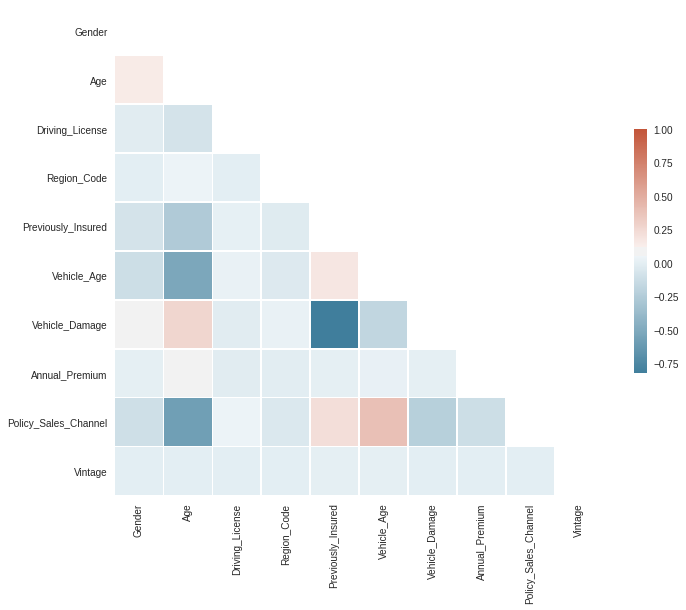

In [5]:
corr = df_train_corr.loc[:,:'Vintage'].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Looks like we have pretty strong negative correlation between 'Vehicle_Damage' and 'Previously_Insured' features, worth exploring it later.

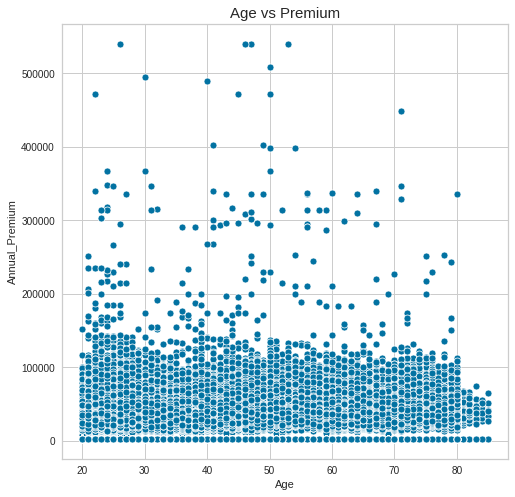

In [6]:
plt.figure(figsize = (8, 8))
sns.scatterplot(df_train_corr['Age'],df_train_corr['Annual_Premium'])
plt.title('Age vs Premium', fontsize = 15)
plt.show()

In [7]:
bins = [10,20, 30, 40, 50, 60, 70, 80, 90, 100]
df_train_corr['bin_age'] = pd.cut(df_train_corr['Age'], bins)
df_train_corr['bin_age']
df_train_corr['age_bin_cat'] = le.fit_transform(df_train_corr['bin_age'])
df_train_corr['age_bin_cat'].value_counts()

1    155229
3     75941
2     55163
4     45305
5     27838
6     15272
0      6232
7       129
Name: age_bin_cat, dtype: int64

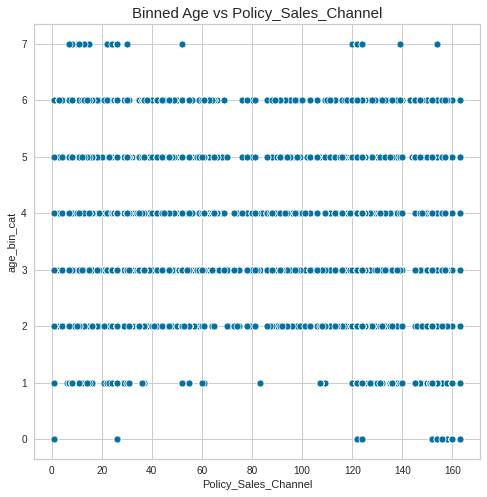

In [8]:
plt.figure(figsize = (8, 8))
sns.scatterplot(df_train_corr['Policy_Sales_Channel'],df_train_corr['age_bin_cat'])
# sns.scatterplot(df_train_corr['age_bin_cat'],df_train_corr['Policy_Sales_Channel'])
plt.title('Binned Age vs Policy_Sales_Channel', fontsize = 15)
plt.show()

In [9]:
X = df_train_corr.loc[:,:'Vintage']
y = df_train_corr.Response
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state = SEED)
        
print(y_train.value_counts())
X_train.head()

0    267547
1     37340
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
74933,1,23,1,31,0,1,1,2630.0,160,52
74767,0,24,1,14,1,1,0,36238.0,152,223
46813,0,25,1,21,0,1,1,32979.0,152,169
56592,0,25,1,5,1,1,0,24476.0,152,202
109992,1,30,1,8,1,0,0,32797.0,26,211


In [10]:
def plot_ROC(fpr, tpr, m_name):
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic for %s'%m_name, fontsize=20)
    plt.legend(loc="lower right", fontsize=16)
    plt.show()

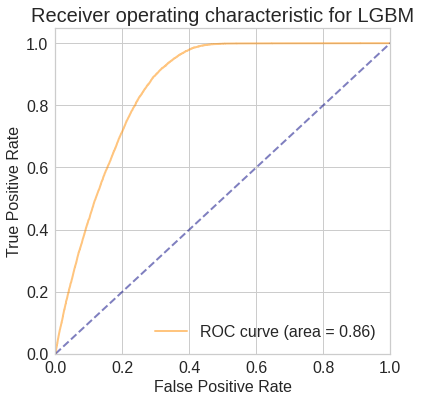

In [11]:
LGB_model = LGBMClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, min_child_weight = 1, verbose  = 1,
                       learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc', is_higher_better = 1, plot = True)
LGB_model.fit(X_train, y_train)
LGB_preds = LGB_model.predict_proba(X_valid)
LGB_class = LGB_model.predict(X_valid)
LGB_score = roc_auc_score(y_valid, LGB_preds[:,1], average = 'weighted')
(fpr, tpr, thresholds) = roc_curve(y_valid, LGB_preds[:,1])
plot_ROC(fpr, tpr, 'LGBM')

ROC AUC score for LGBM model: 0.8574
F1 score: 0.0528


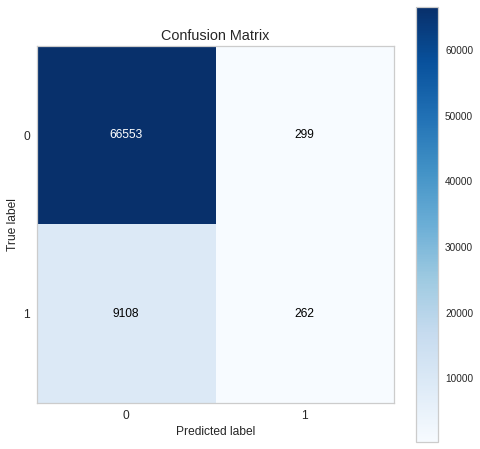

In [12]:
print('ROC AUC score for LGBM model: %.4f'%LGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, LGB_class))
skplt.metrics.plot_confusion_matrix(y_valid, LGB_class, figsize=(8,8))

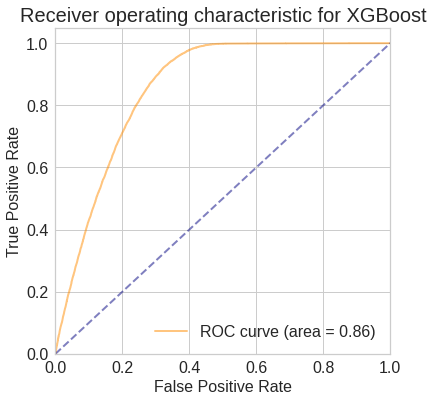

In [13]:
XGB_model = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')
XGB_model.fit(X_train, y_train)
XGB_preds = XGB_model.predict_proba(X_valid)
XGB_class = XGB_model.predict(X_valid)
XGB_score = roc_auc_score(y_valid, XGB_preds[:,1], average = 'weighted')

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds[:,1])
plot_ROC(fpr, tpr, 'XGBoost')

ROC AUC score for XGBoost model: 0.8553
F1 score: 0.0750


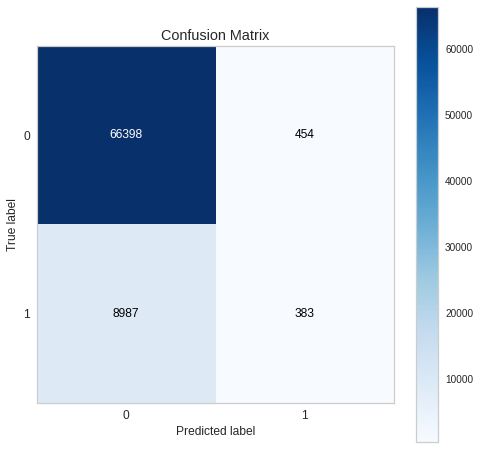

In [14]:
print('ROC AUC score for XGBoost model: %.4f'%XGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class, figsize=(8,8))

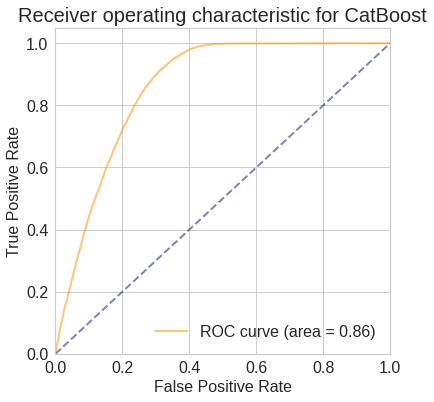

In [15]:
Cat_model = CatBoostClassifier( iterations = 300, random_seed = SEED, task_type = 'CPU',
    learning_rate = 0.5, custom_loss = ['AUC', 'Accuracy'] )
Cat_model.fit(X_train, y_train, cat_features = categorical_features, eval_set = (X_valid, y_valid), verbose = False, plot = False)
Cat_preds = Cat_model.predict_proba(X_valid)
Cat_class = Cat_model.predict(X_valid)
Cat_score = roc_auc_score(y_valid, Cat_preds[:,1], average = 'weighted')

(fpr, tpr, thresholds) = roc_curve(y_valid, Cat_preds[:,1])
plot_ROC(fpr, tpr, 'CatBoost')

ROC AUC score for CatBoost model: 0.8578
F1 score: 0.0401


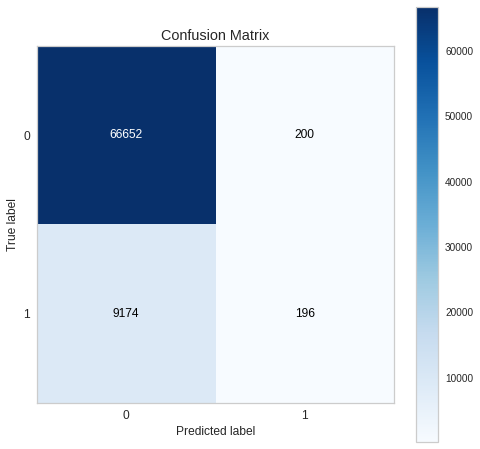

In [16]:
print('ROC AUC score for CatBoost model: %.4f'%Cat_score)
print('F1 score: %0.4f'%f1_score(y_valid, Cat_class))
skplt.metrics.plot_confusion_matrix(y_valid, Cat_class, figsize=(8,8))

Lets check if ensembling would give us some boost. <span style="text-decoration: line-through;">And it looks like it's not really helpful in this case. </span>After analyzing confusion matrices we actually see that all 3 models have terrible false negative rate, and underwhelming F1 score therefore (although somewhat decent AUC).  Moreover averaged result is even worse despite slightly increasing AUC  :(

Averaged score: 0.8585
Averaged F1 score: 0.0199


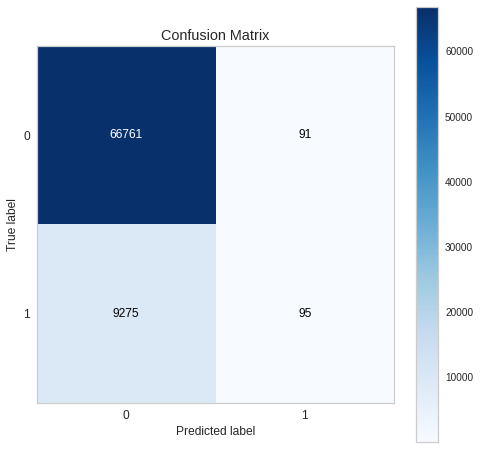

In [17]:
# plain averaging
avg_preds3 = (Cat_preds+LGB_preds+XGB_preds)/3
avg_class3 = ((Cat_class+LGB_class+XGB_class)/3).astype('int32')
score_avg3 = roc_auc_score(y_valid, avg_preds3[:,1], average = 'weighted')
print('Averaged score: %.4f'%score_avg3)
print('Averaged F1 score: %.4f'%f1_score(y_valid, avg_class3))
skplt.metrics.plot_confusion_matrix(y_valid, avg_class3, figsize=(8,8))

Now lets check if converting remaining categorical values to one-hot encoded features would help XGBoost.

In [18]:
df_train_01 = df_train.copy().set_index('id')
for f in categorical_features:
    df_train_01[f] = le.fit_transform(df_train_01[f])

# df_train_01.head()
y01 = df_train_01.Response
X01 = df_train_01.loc[:,:'Vintage']

sales = pd.get_dummies(X01.Policy_Sales_Channel, prefix = 'Sales')
code = pd.get_dummies(X01.Region_Code, prefix = 'Code')
vehicle_age = pd.get_dummies(X01.Vehicle_Age, prefix = 'Vehicle_Age')
X_one_hot = pd.concat([X01, sales], axis = 1)
X_one_hot = pd.concat([X_one_hot, code], axis = 1)
X_one_hot = pd.concat([X_one_hot, vehicle_age], axis = 1)
X_one_hot = X_one_hot.drop(columns = ['Policy_Sales_Channel','Region_Code', 'Vehicle_Age'])
print(X_one_hot.columns)

Index(['Gender', 'Age', 'Driving_License', 'Previously_Insured', 'Vehicle_Damage', 'Annual_Premium', 'Vintage', 'Sales_0', 'Sales_1', 'Sales_2',
       ...
       'Code_46', 'Code_47', 'Code_48', 'Code_49', 'Code_50', 'Code_51', 'Code_52', 'Vehicle_Age_0', 'Vehicle_Age_1', 'Vehicle_Age_2'], dtype='object', length=218)


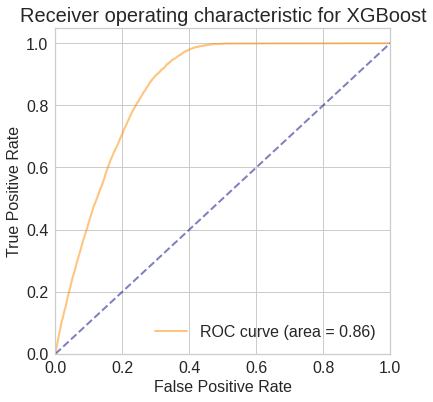

In [19]:
X0_train, X0_valid, y0_train, y0_valid = train_test_split(X_one_hot, y01, train_size=0.8, random_state = SEED)

XGB_model_01 = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')
XGB_model_01.fit(X0_train, y0_train)
XGB_preds0 = XGB_model_01.predict_proba(X0_valid)
XGB_score0 = roc_auc_score(y0_valid, XGB_preds0[:,1], average = 'weighted')
XGB_class0 = XGB_model_01.predict(X0_valid)

(fpr, tpr, thresholds) = roc_curve(y0_valid, XGB_preds0[:,1])
plot_ROC(fpr, tpr,'XGBoost')

In [20]:
print('ROC AUC score for XGBoost model with One Hot Encoded categorical features: %.4f'%XGB_score0)
print('F1 score: %0.4f'%f1_score(y0_valid, XGB_class0))
print('Confusion matrix:')
print(confusion_matrix(y0_valid, XGB_class0))
# and for easier comparison lets do it again here
print('-'*20)
print('ROC AUC score for XGBoost model with categorical features not encoded: %.4f'%XGB_score)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class))
print('Confusion matrix with categorical features not encoded:')
print(confusion_matrix(y_valid, XGB_class))

ROC AUC score for XGBoost model with One Hot Encoded categorical features: 0.8552
F1 score: 0.0654
Confusion matrix:
[[66465   387]
 [ 9040   330]]
--------------------
ROC AUC score for XGBoost model with categorical features not encoded: 0.8553
F1 score: 0.0750
Confusion matrix with categorical features not encoded:
[[66398   454]
 [ 8987   383]]


Looks like in this case the same model performs better when categorical features are not one-hot encoded. But it's precision is terrible still...

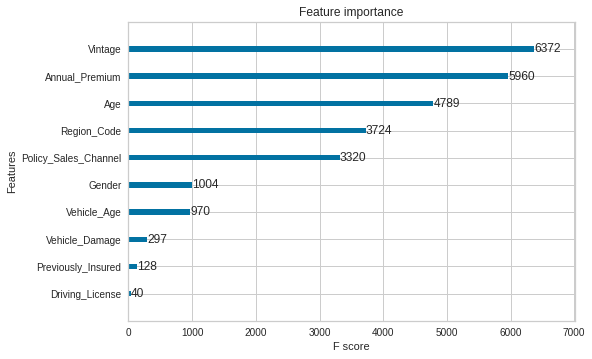

In [21]:
xgb.plot_importance(XGB_model)

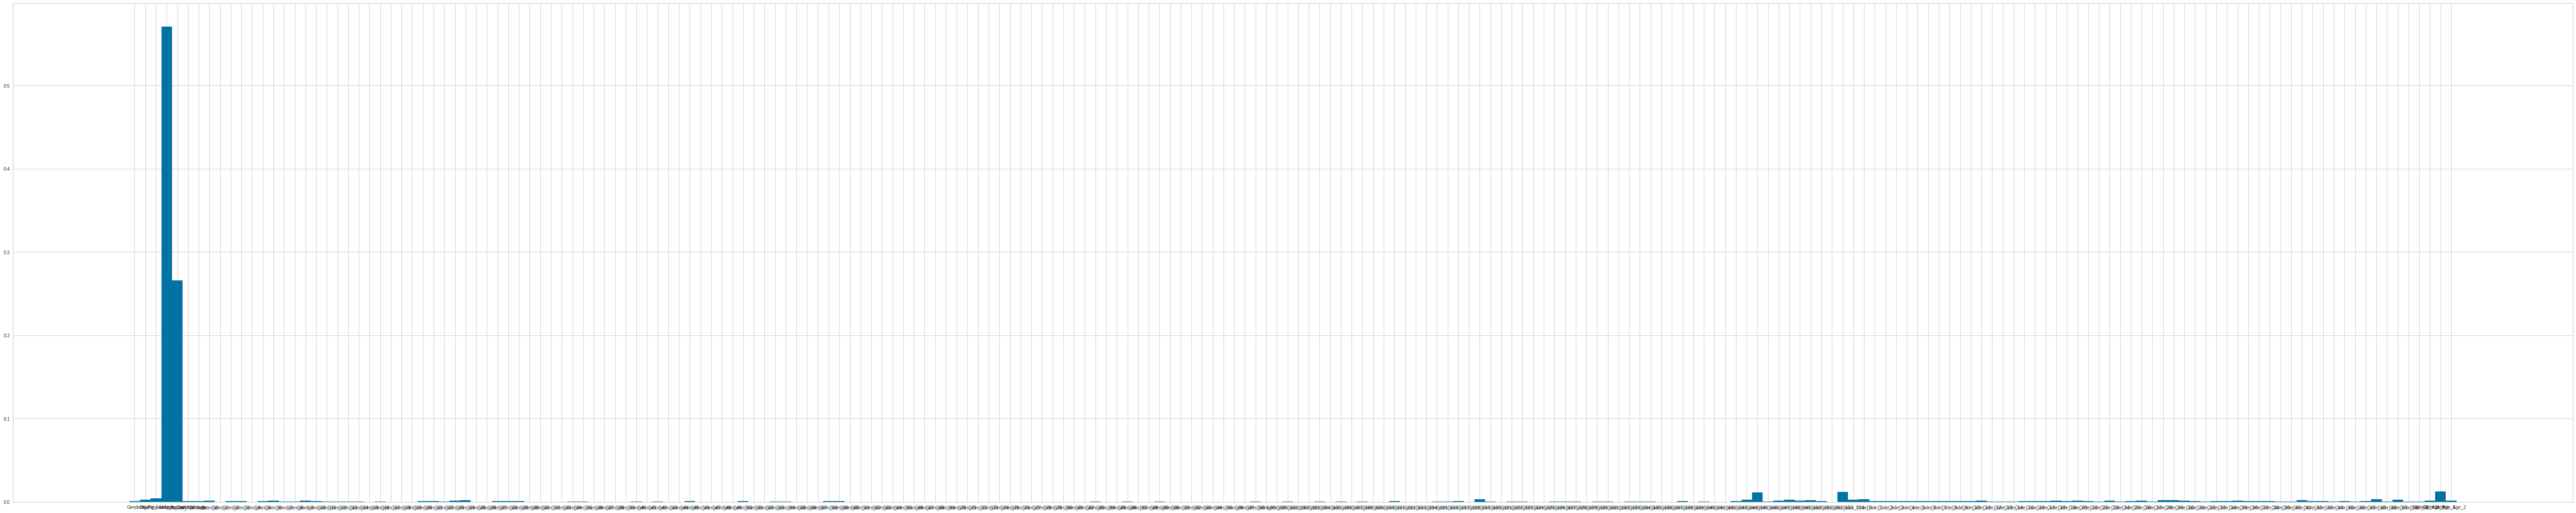

In [22]:
plt.figure(figsize=(100, 20))
plt.bar(X0_train.columns,XGB_model_01.feature_importances_, 1)
plt.show()

It's difficult to see exact feature names that influenced the model the most, but it's clearly ones from the original set of not one-hot encoded. Some of the encoded features also had some importance although few times less impactful.

Now lets try to deal with imbalance of the classes via built-in 'scale_pos_weight', although most likely it won't help much. I'll continue experimienting with XGBoost as it seems to be getting slightly better results.

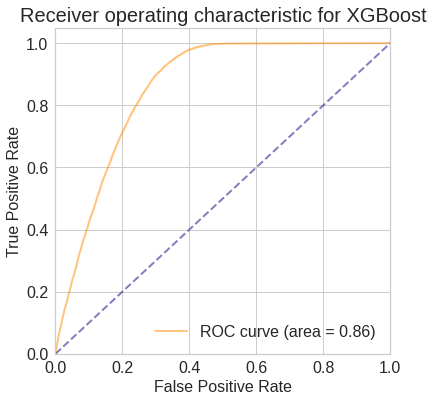

In [23]:
XGB_model_b = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          scale_pos_weight = 0.9,
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_b.fit(X_train, y_train)
XGB_preds_b = XGB_model_b.predict_proba(X_valid)
XGB_score_b = roc_auc_score(y_valid, XGB_preds_b[:,1], average = 'weighted')
XGB_class_b = XGB_model_b.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_b[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model: 0.8551
F1 score: 0.0513


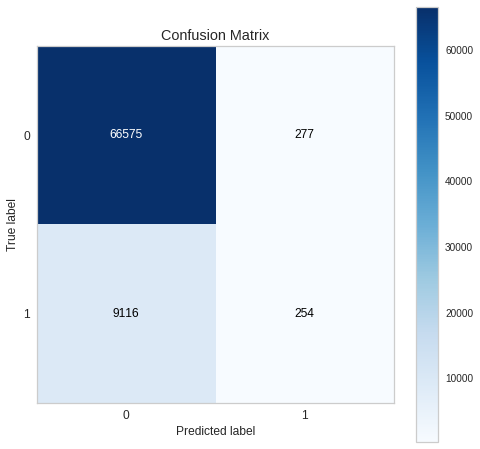

In [24]:
print('ROC AUC score for XGBoost model: %.4f'%XGB_score_b)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_b))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_b, figsize=(8,8))

As expected there is no improvement.

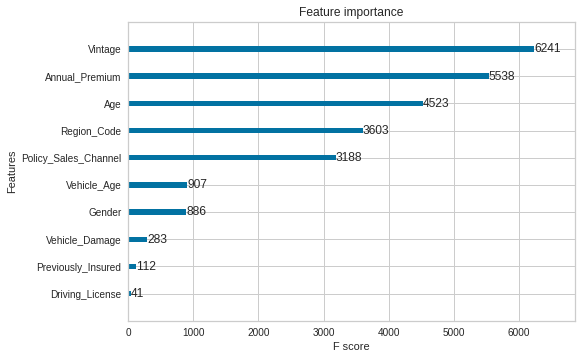

In [25]:
xgb.plot_importance(XGB_model_b)

Brute-force oversampling of Positive Response class, and engineering 2 new synthetic features

In [26]:
def upsample_all(df, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        df['Annual_Premium'] = ones['Annual_Premium'].apply(lambda x: x + random.randint(-1,1)* x *0.1)
        df['Age'] = ones['Age'].apply(lambda x: x + random.randint(-5,5))
        df['Vintage'] = ones['Vintage'].apply(lambda x: x + random.randint(-5,5))
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

def upsample(df, u_feature, n_upsampling):
    ones = df.copy()
    for n in range(n_upsampling):
        if u_feature == 'Annual_Premium':
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-1,1)* x *0.05)
        else:
            df[u_feature] = ones[u_feature].apply(lambda x: x + random.randint(-5,5))
                
        if n == 0:
            df_new = df.copy()
        else:
            df_new = pd.concat([df_new, df])
    return df_new

try:
    df_train_corr.drop(columns = ['bin_age'], inplace = True)
except:
    print('already deleted')        

df_train_mod = df_train_corr.copy()
df_train_mod['old_damaged'] = df_train_mod.apply(lambda x: pow(2,x.Vehicle_Age)+pow(2,x.Vehicle_Damage), axis =1)

# we shall preserve validation set without augmentation/over-sampling
dft, X_valid, yft, y_valid = train_test_split(df_train_mod, df_train_mod['Response'], train_size=0.8, random_state = SEED)
X_valid = X_valid.drop(columns = ['Response'])

# upsampling Positive Response class only
df_train_up_a = upsample(dft.loc[dft['Response'] == 1], 'Age', 1)
df_train_up_v = upsample(dft.loc[dft['Response'] == 1], 'Vintage', 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
df_train_mod.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,age_bin_cat,old_damaged
id,,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,1,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,0,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,1,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,0,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,0,1,3.0


In [28]:
df_ext = pd.concat([df_train_mod,df_train_up_a])
df_ext = pd.concat([df_ext,df_train_up_v])
Xe = df_ext.drop(columns = ['Response'])
ye = df_ext.Response
print(ye.value_counts())
Xe.head()

0    334399
1    121390
Name: Response, dtype: int64


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,age_bin_cat,old_damaged
id,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,1,3.0


In [29]:
X_train = Xe.copy()
y_train = ye.copy()
print('Validation set target class count: ')
print(y_valid.value_counts())
print('Train set target class count with over-sampling:')
print(ye.value_counts())

Validation set target class count: 
0    66852
1     9370
Name: Response, dtype: int64
Train set target class count with over-sampling:
0    334399
1    121390
Name: Response, dtype: int64


In [30]:
X_train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,age_bin_cat,old_damaged
id,,,,,,,,,,,,
1,1,44,1,28,0,2,1,40454.0,26,217,3,6.0
2,1,76,1,3,0,0,0,33536.0,26,183,6,2.0
3,1,47,1,28,0,2,1,38294.0,26,27,3,6.0
4,1,21,1,11,1,1,0,28619.0,152,203,1,3.0
5,0,29,1,41,1,1,0,27496.0,152,39,1,3.0


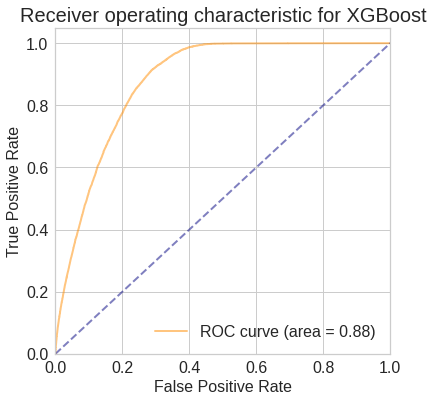

In [31]:
XGB_model_u = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_u.fit(X_train, y_train)
XGB_preds_u = XGB_model_u.predict_proba(X_valid)
XGB_score_u = roc_auc_score(y_valid, XGB_preds_u[:,1], average = 'weighted')
XGB_class_u = XGB_model_u.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_u[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model with over-sampling + 2 new features: 0.8782
F1 score: 0.4780


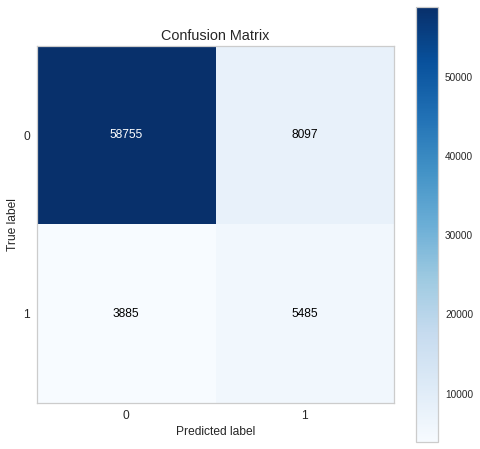

In [32]:
print('ROC AUC score for XGBoost model with over-sampling + 2 new features: %.4f'%XGB_score_u)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_u))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_u,
        figsize=(8,8))

Now we got much better True Positives, but False Positives are way too bad at the same time.

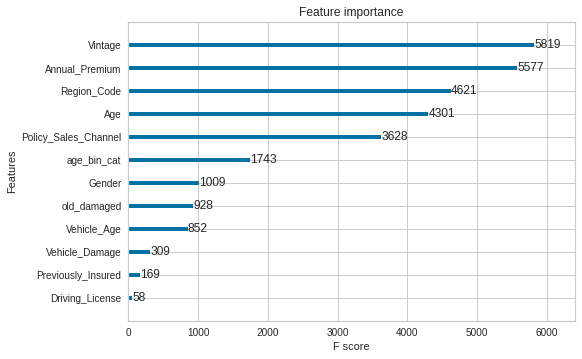

In [33]:
xgb.plot_importance(XGB_model_u)

Since we saw that 2 features were correlated: 'Previously_Insured' and 'Vehicle_Damage', and the former is less significant for the decision making we'd drop it.

In [34]:
X_train.drop(columns = ['Previously_Insured', 'Driving_License','Vehicle_Age','Vehicle_Damage'], inplace = True)
X_valid.drop(columns = ['Previously_Insured', 'Driving_License','Vehicle_Age','Vehicle_Damage'], inplace = True)
# X_train.drop(columns = ['Previously_Insured'], inplace = True)
# X_valid.drop(columns = ['Previously_Insured'], inplace = True)

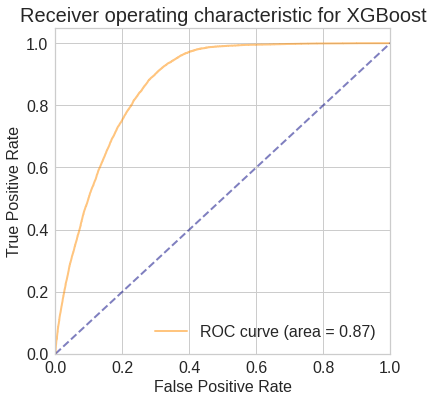

In [35]:
XGB_model_ud = XGBClassifier(random_state = SEED, max_depth = 8, n_estimators = 300, reg_lambda = 1.2, reg_alpha = 1.2, 
                          min_child_weight = 1, 
                          objective = 'binary:logistic',
                          learning_rate = 0.15, gamma = 0.3, colsample_bytree = 0.5, eval_metric = 'auc')

XGB_model_ud.fit(X_train, y_train)
XGB_preds_ud = XGB_model_ud.predict_proba(X_valid)
XGB_score_ud = roc_auc_score(y_valid, XGB_preds_ud[:,1], average = 'weighted')
XGB_class_ud = XGB_model_ud.predict(X_valid)

(fpr, tpr, thresholds) = roc_curve(y_valid, XGB_preds_ud[:,1])
plot_ROC(fpr, tpr,'XGBoost')

ROC AUC score for XGBoost model with over-sampling, and 4 features removed: 0.8688
F1 score: 0.4588


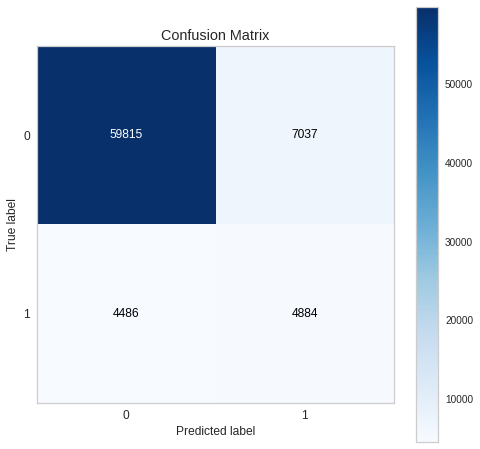

In [36]:
print('ROC AUC score for XGBoost model with over-sampling, and 4 features removed: %.4f'%XGB_score_ud)
print('F1 score: %0.4f'%f1_score(y_valid, XGB_class_ud))
skplt.metrics.plot_confusion_matrix(y_valid, XGB_class_ud,
        figsize=(8,8))

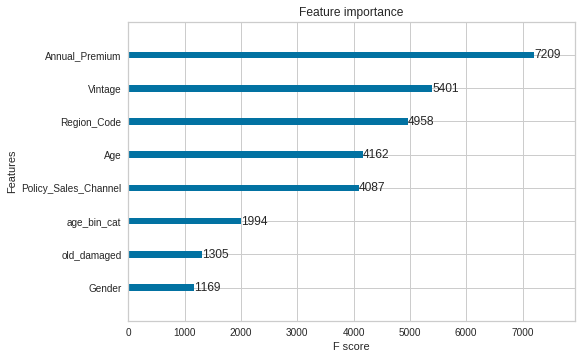

In [37]:
xgb.plot_importance(XGB_model_ud)

Time to compare boosted trees with classical approaches like Logistic Regression, Random Forest etc.

In [38]:
# we must scale data for logistic regression algorithm, so all features would appear equally important
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled = scaler.fit_transform(X_one_hot[['Age','Vintage', 'Annual_Premium']])
X_one_hot_scaled = X_one_hot.copy()
X_one_hot_scaled[['Age','Vintage', 'Annual_Premium']] = scaled

X0_train_scaled, X0_valid_scaled, y0_train, y0_valid = train_test_split(X_one_hot_scaled, y01, train_size=0.8, random_state = SEED)

ROC AUC score for Logistic Regression model: 0.5007
Simple Logistic Regression f1_score:  0.004028837998303647


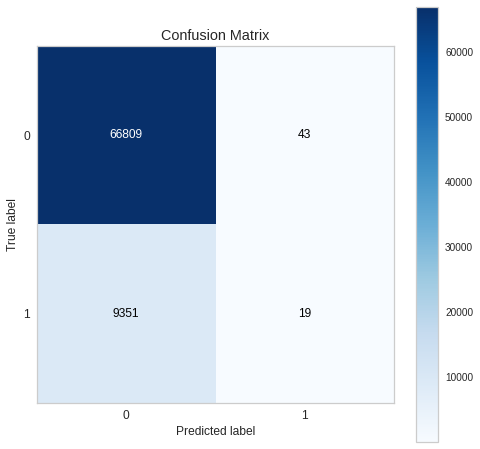

In [39]:
# just a reminder that X_train, y_train contain engineered features and twice oversampled, while X0_train, y0_train is for OneHotEncoded categoticals without oversampling
reg_clf = LogisticRegression(random_state = SEED,
                             solver = 'lbfgs',
                            max_iter=1000)
reg_clf.fit(X0_train_scaled, y0_train)
reg_preds = reg_clf.predict(X0_valid_scaled)
reg_score_ud = roc_auc_score(y0_valid, reg_preds, average = 'weighted')

print('ROC AUC score for Logistic Regression model: %.4f'%reg_score_ud)
print('Simple Logistic Regression f1_score: ', f1_score(y0_valid, reg_preds))
skplt.metrics.plot_confusion_matrix(y0_valid, reg_preds,figsize=(8,8))

Both AUC and F1 scores are misrable for Logistic Regression. It should not be that bad for sure, will need to come back to it later...<br>
Lets check Random Forest on OneHot encoded categorical features dataset too.

ROC AUC score for Random Forest model with categorical features one-hot-encoded: 0.8538
Random Forest f1-score 0.003402807316035729


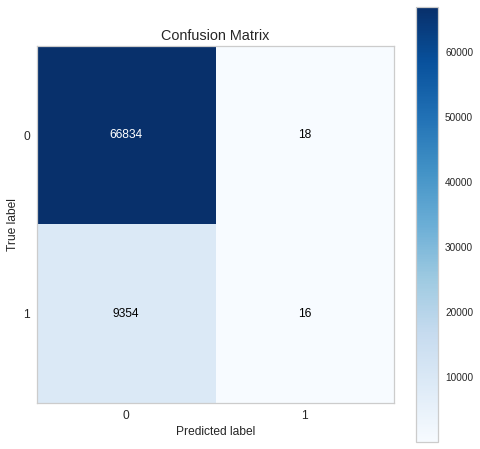

In [40]:
rf_params = {'max_depth': 20, 'n_estimators': 30, 'min_samples_leaf': 1}
rf_params['random_state'] = SEED
rf = RandomForestClassifier(**rf_params)
rf.fit(X0_train, y0_train)
rf_preds = rf.predict(X0_valid)
rf_preds_prob = rf.predict_proba(X0_valid)[:,1]

reg_score_uc = roc_auc_score(y0_valid, rf_preds_prob, average = 'weighted')
print('ROC AUC score for Random Forest model with categorical features one-hot-encoded: %.4f'%reg_score_uc)
print('Random Forest f1-score', f1_score(y0_valid, rf_preds))
skplt.metrics.plot_confusion_matrix(y0_valid, rf_preds,figsize=(8,8))

Using Random Forest we get quite decent AUC score while F1 score is proving that the precision is still failing.<br>
Lets see how RF will deal with the augmented dataset, with new synthetic features and no one-hot encoding applied.

# And the winner is...
Random Forest applied to the augmented set with 2 engineered features got us the most remarkable score to date (9/25/2020), and I'm quite sure there is some room for improvement.

ROC AUC score for RandomForest model with over-sampling: 0.9200
Optimized RF f1-score 0.5644615673745537


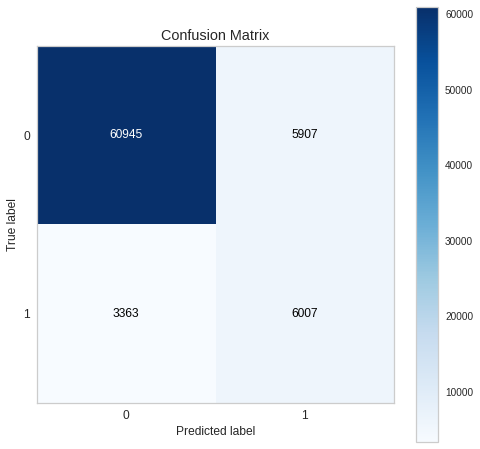

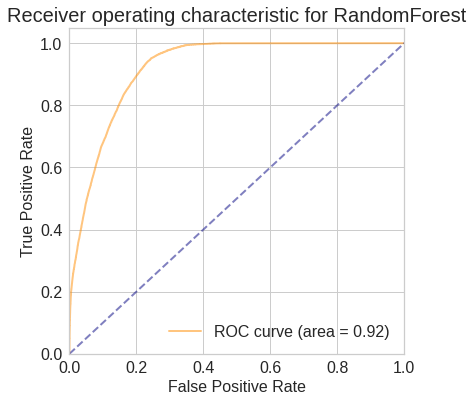

In [41]:
rf_params = {'max_depth': 20, 'n_estimators': 300, 'min_samples_leaf': 1}
rf_params['random_state'] = SEED
rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_valid)
rf_preds_prob = rf.predict_proba(X_valid)[:,1]

reg_score_uc = roc_auc_score(y_valid, rf_preds_prob, average = 'weighted')
print('ROC AUC score for RandomForest model with over-sampling: %.4f'%reg_score_uc)
print('Optimized RF f1-score', f1_score(y_valid, rf_preds))
skplt.metrics.plot_confusion_matrix(y_valid, rf_preds,figsize=(8,8))

(fpr, tpr, thresholds) = roc_curve(y_valid, rf_preds_prob)
plot_ROC(fpr, tpr,'RandomForest')

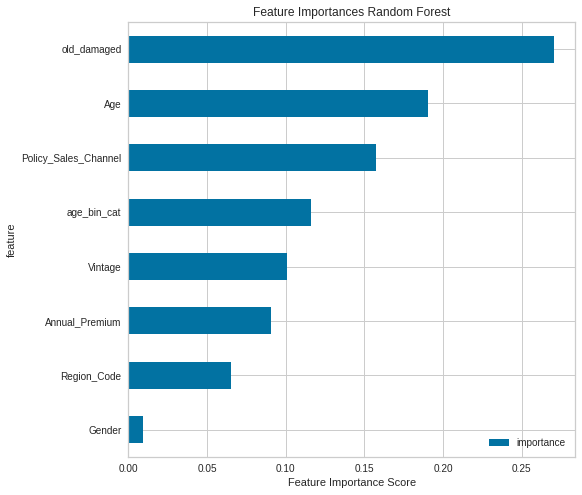

In [42]:
title="Feature Importances Random Forest"
feat_imp = pd.DataFrame({'importance':rf.feature_importances_}) 
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=True, inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=(8,8))
plt.xlabel('Feature Importance Score')
plt.show()

In [43]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1970,
 'verbose': 0,
 'warm_start': False}

# TO-DO
Try to improve XGBoost and CatBoost through fine-tuning, and try to beat Random Forest on augmented data. <br>
KFold croos-validation might help, but I don't expect it to give a breakthrough improvement, so it is a low priority for now. <br>
And think of more feature engineering...<br>
More experiments coming.

<strike>**Big question** - was AUC the right metric for this problem, or would F1 be better?</strike> <br>
<p style = 'font-size : medium; font-weight: bold; color : brown'> I'm quite sure now that the metric must be F1 for this task to produce usable predictions</p>